In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import src.data_processing.load_data
plt.style.use('seaborn-poster')

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Get the data and pick an infant #10 from the NYU dataset as an example

In [24]:
sleep, time0 = src.data_processing.load_data.get_sleep('12/06/2021', '../data/')
data = pd.read_csv('../data/NYU_data_processed/NYU_sleep_df.csv', index_col = 0)
timeseries = pd.date_range(start = '1/1/2020', end = '31/12/2020', freq = '10min')[:-1]

/Users/olegdubinkin/Documents/Python/PyCharm/BabySleep/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3361: UserWarning: Parsing '31/12/2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [44]:
infant = '10'
newinfant = data[infant] - data.trend
newinfant = pd.Series(data = newinfant.values, index = timeseries)
st = 120 * 24 * 6
en = st + 30 * 24 * 6
trend = pd.Series(data = data.trend.values, index = timeseries)

In [45]:
decomp = seasonal_decompose(newinfant[st : en], period = 144)

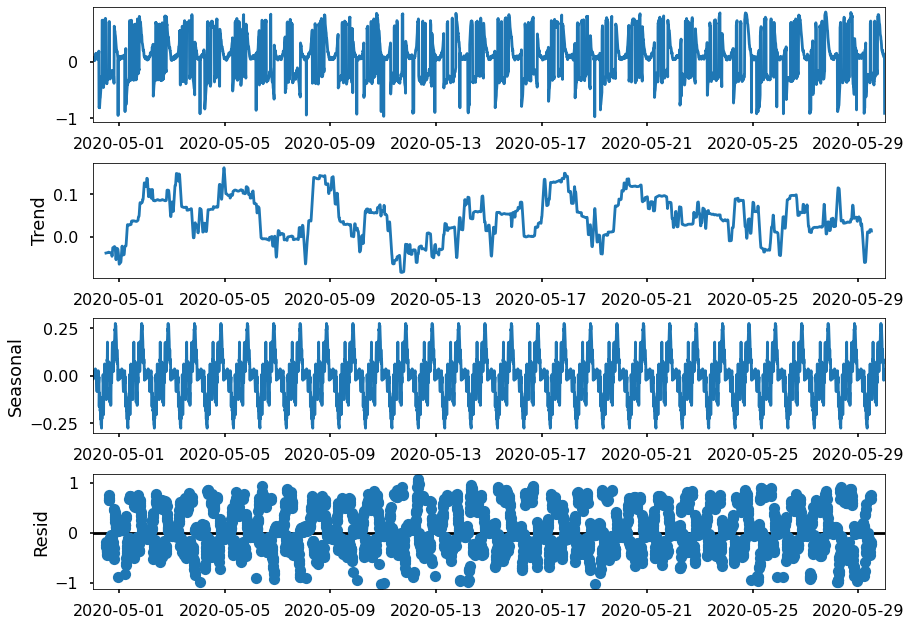

<Figure size 921.6x633.6 with 0 Axes>

In [47]:
decomp.plot()
plt.show()
plt.savefig('ppp.png')

Here we see a strong seasonal component, just as expected. There's no overall trend in the data, so the ADF will clearly get a 0 p-value, even though the series is non-stationary due to seasonality.

/Users/olegdubinkin/Documents/Python/PyCharm/BabySleep/venv/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


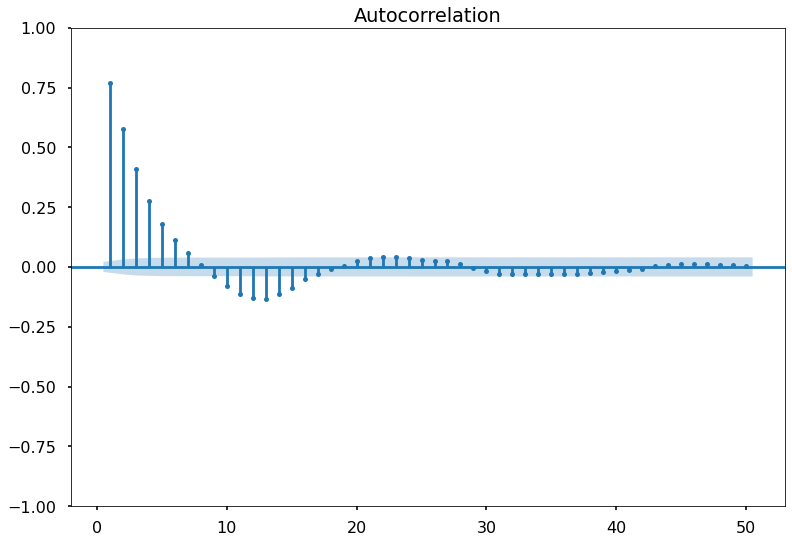

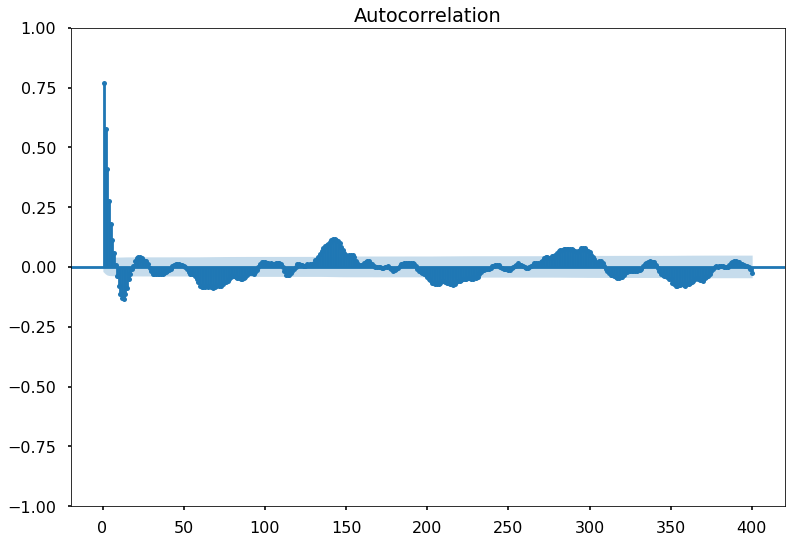

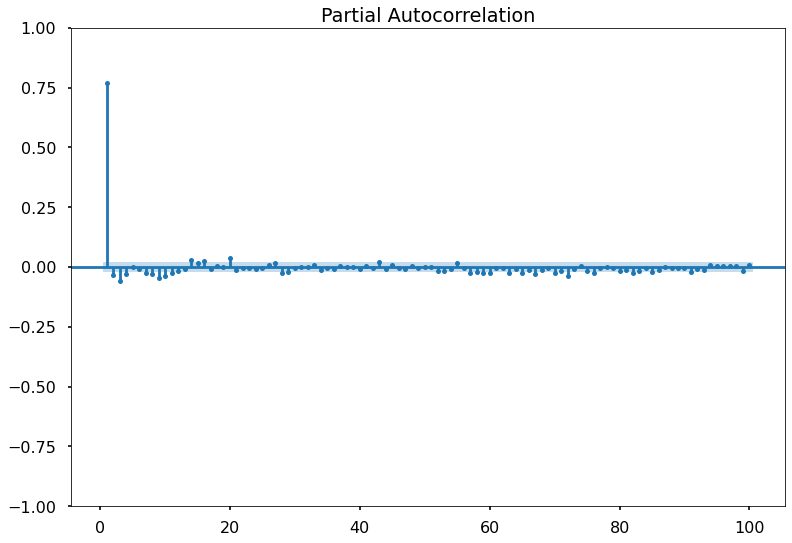

In [33]:
en = st + 60 * 24 * 6
plot_acf(pd.Series(newinfant)[st : en], lags = 50, zero = False);
plot_acf(pd.Series(newinfant)[st : en], lags = 400, zero = False);
plot_pacf(pd.Series(newinfant)[st : en], lags = 100, zero = False);

The ACF plot and tapering off PACF suggest the value p=8 and q=0

/Users/olegdubinkin/Documents/Python/PyCharm/BabySleep/venv/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


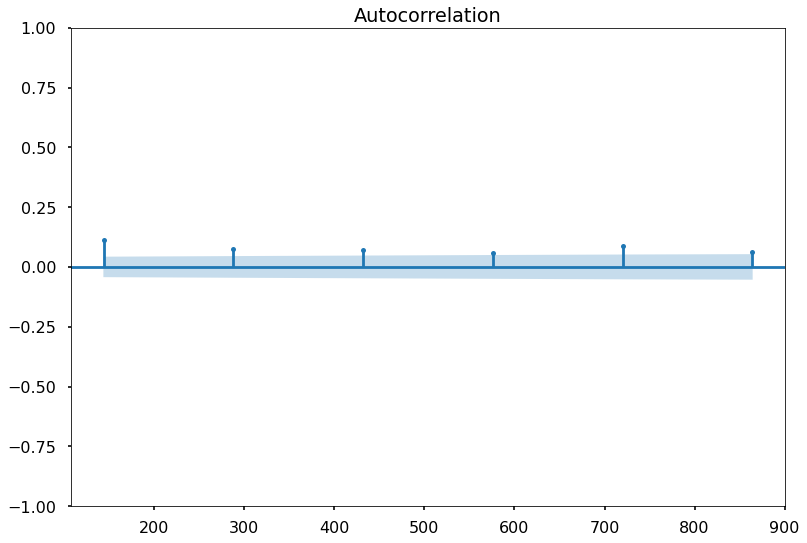

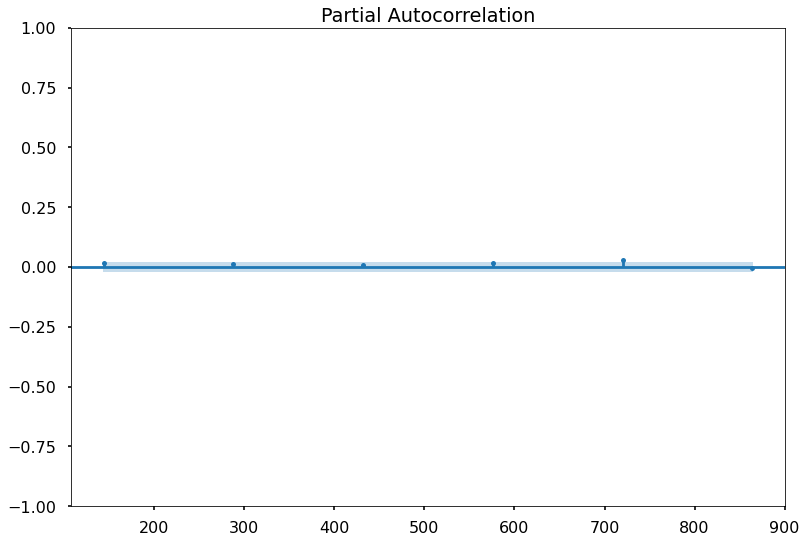

In [34]:
laglist = [144, 2*144, 3*144, 4*144, 5*144, 6*144]
plot_acf(pd.Series(newinfant)[st : en], lags = laglist, zero = False);
plot_pacf(pd.Series(newinfant)[st : en], lags = laglist, zero = False);

Again, from the seasonal ACF and PACF plots we would expect that the seasonal p will be non-zero, while the seasonal q will be equal to 0. However, it is worthwhile doing the grid search to find the optimal values. Since we are interested in the highest predictive power, we will sort our results by the AIC score:

In [274]:
order_aic_bic=[]

for p in range(1,4):
    for q in range(3):
        for ps in range(1,4):
            for qs in range(3):
                mod = SARIMAX(newinfant[st:en], 
                              order=(8 + p, 0, q),
                              seasonal_order = (ps, 1, qs, 144))
                res = mod.fit()
                order_aic_bic.append((p, q, ps, qs, res.aic, res.bic))

order_df = pd.DataFrame(order_aic_bic, 
                        columns=['p', 'q', 'ps', 'qs', 'AIC', 'BIC'])

print(order_df.sort_values('AIC'))

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: Convergenc

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


    p  q  ps  qs         AIC         BIC
31  2  0   2   1  290.113987  362.709405
58  3  0   2   1  291.492253  369.273059
34  2  0   3   1  291.722916  369.503721
40  2  1   2   1  291.837612  369.618417
32  2  0   2   2  291.896767  369.677572
49  2  2   2   1  291.972061  374.938253
67  3  1   2   1  292.639710  375.605902
61  3  0   3   1  293.063945  376.030137
13  1  1   2   1  293.182339  365.777757
43  2  1   3   1  293.431679  376.397872
76  3  2   2   1  293.474738  381.626317
59  3  0   2   2  293.484898  376.451090
52  2  2   3   1  293.863719  382.015298
35  2  0   3   2  293.897220  376.863413
70  3  1   3   1  294.191878  382.343458
4   1  0   2   1  294.412956  361.822987
28  2  0   1   1  294.712525  362.122556
16  1  1   3   1  294.842147  372.622953
79  3  2   3   1  295.004742  388.341709
62  3  0   3   2  295.260574  383.412154
44  2  1   3   2  295.613034  383.764613
53  2  2   3   2  295.865116  389.202082
55  3  0   1   1  296.117692  368.713110
7   1  0   3   1

In [275]:
order_df.sort_values('AIC').to_csv('SARIMAX_model_selection_p=8+p_d=0_ds=1_s=144.csv')

It seems that the optimal parameters for the SARIMAX model are (10, 0, 0)(2, 1, 1, 144). The order of differentiation was found previously by previous experimentation with the model.